In [18]:
# !pip install h3==3.7.6 --force-reinstall
# !pip install --upgrade shapely
# !pip install osmnx --upgrade
# !pip install shap
# !pip install lightgbm
# !pip install optuna

!pip install yellowbrick

In [27]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
from h3 import geo_to_h3, h3_to_geo
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib
matplotlib.rc('font', family='DejaVu Sans')
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import optuna
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [3]:
H3_RESOLUTION = 8

In [4]:
#load the data

start_time = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  # Remove .gz
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

os.remove(file_name)  # Optional: clean up compressed file

df = pd.read_csv(csv_name)

print(f"Loaded {file_name} in {time.time() - start_time:.2f} seconds")

Processing sr_hex.csv.gz...
Loaded sr_hex.csv.gz in 7.69 seconds


In [5]:
# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(941634, 16)
(729270, 16)


In [6]:
#Filter out records for target type

target_type = 'Sewer: Blocked/Overflow'
df_type = df[df['code'] == target_type].groupby(['h3_level8_index'])['notification_number'].count().reset_index(name='num_requests')

In [ ]:
df_type.head(2)

,h3_level8_index,num_requests
0,88ad360001fffff,21
1,88ad360003fffff,12


In [11]:
#Helper function
def h3_to_point(h3, resolution=8):
    return h3_to_geo(h3)

# Convert each h3_index to lat/lon
df_type[['latitude', 'longitude']] = df_type['h3_level8_index'].apply(lambda h: pd.Series(h3_to_point(h)))

In [12]:
df_type.head(2)

,h3_level8_index,num_requests,latitude,longitude
0,88ad360001fffff,21,-33.836215,18.494065
1,88ad360003fffff,12,-33.832471,18.485002


## Initial Solution - Baseline Model

In [33]:

X = df_type.drop(['num_requests'], axis=1)
X = X.set_index('h3_level8_index')
y = df_type['num_requests']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#_train = np.log1p(y_train)
regressor = RandomForestRegressor(n_estimators = 50,oob_score = True)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
#y_pred = np.expm1(y_log_pred)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

Out-of-Bag Score: 0.2667607922823855
RMSE: 113.9474978766117
R2: 0.314927919756133


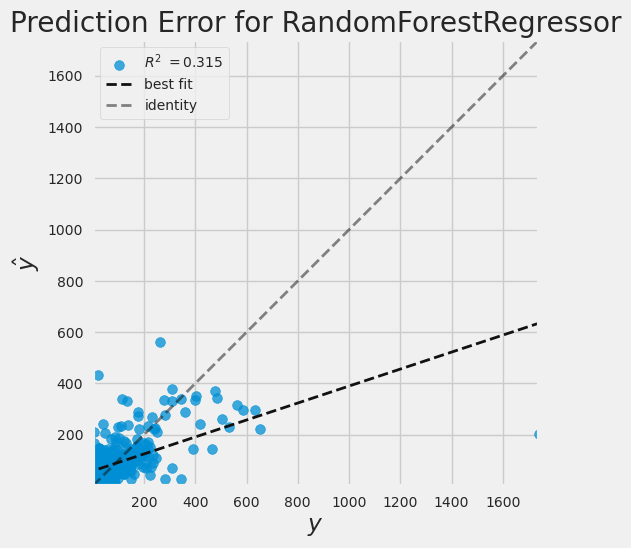

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [34]:
visualizer = PredictionError(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

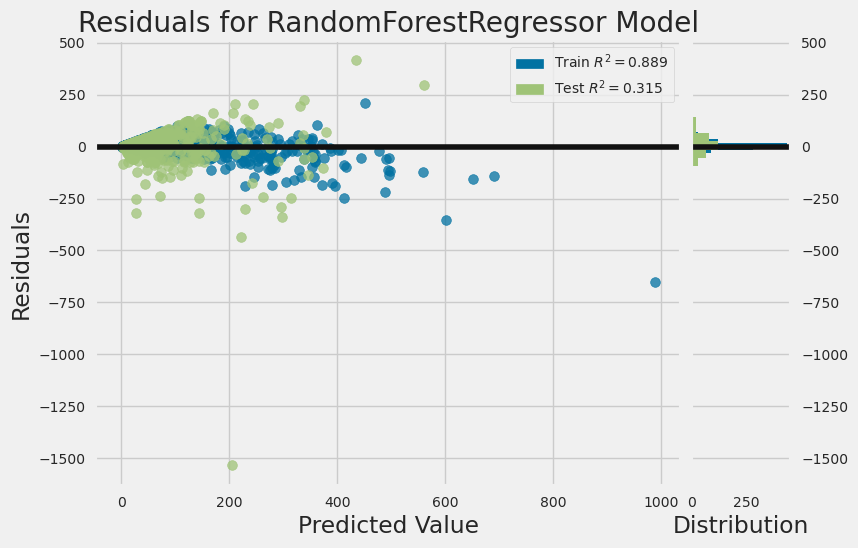

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
visualizer = ResidualsPlot(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure